In [3]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,sklearn,pandas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Fri Feb 15 2019 

CPython 3.6.8
IPython 7.2.0

numpy 1.14.6
scipy 1.1.0
sklearn 0.20.1
pandas 0.24.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.20.5-arch1-1-ARCH
machine    : x86_64
processor  : 
CPU cores  : 16
interpreter: 64bit


In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import nolds
import data
import mne

PROJ_ROOT = os.getenv('THESIS_ROOT')
DATA_ROOT = os.path.abspath(os.path.join(PROJ_ROOT, 'data'))
PROCESSED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'processed'))
RAW_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'raw'))
LABELED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'labeled'))
DURATIONS_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'durations'))
REC_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'recplots'))
DIRECT_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'direct'))
GAF_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'gaf'))
print(PROJ_ROOT)
print(DATA_ROOT)
print(PROCESSED_ROOT)
import sys
sys.path.append(os.path.join(PROJ_ROOT, 'src'))
CHANNEL_NAMES = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
META_COLUMN_NAMES = ['freq', 'RESP_4W', 'RESP_FIN', 'REMISE_FIN', 'AGE', 'SEX', 'M_1',
       'M_4', 'M_F', 'délka léčby', 'lék 1', 'lék 2', 'lék 3', 'lék 4']
META_FILE_NAME = 'DEP-POOL_Final_144.xlsx'
# meta_df = pd.read_excel(os.path.join(RAW_ROOT, META_FILE_NAME), index_col='ID', names=META_COLUMN_NAMES)

raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '50a.fif'))
t = pd.DataFrame(raw_fif.get_data())
data = pd.DataFrame(np.transpose(t.values), columns=CHANNEL_NAMES).values

/home/kovar/thesis_project/
/home/kovar/thesis_project/data
/home/kovar/thesis_project/data/processed
Opening raw data file /home/kovar/thesis_project/data/processed/50a.fif...
This filename (/home/kovar/thesis_project/data/processed/50a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16930 =      0.000 ...    67.720 secs
Ready.


<ipython-input-4-1e7cd7d477f5>:32: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/50a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '50a.fif'))


# Models

In [3]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

Using TensorFlow backend.


In [5]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential
from keras import optimizers
from keras import initializers

from keras import backend as K
# K.set_floatx('float32')
# K.floatx()
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


# Prepare data

In [8]:
def f(row, col):
    if row[col] <= 17:
        return -1
    if row[col] <= 27:
        return 0
    else:
        return 1
def ff(row, col, n=5):
    for i in range(n):
        if row[col] <= metapkl.quantile((i+1)/n)[col]:
            return i
    
metapklpath = os.path.join(LABELED_ROOT, 'processed', 'meta', 'meta.pkl')
metapkl = pd.read_pickle(metapklpath)
metapkl['dep'] = metapkl.apply(lambda row: f(row, 'sc'), axis=1)
metapkl['dep_bef'] = metapkl.apply(lambda row: f(row, 'sc_bef'), axis=1)
metapkl['dep_aft'] = metapkl.apply(lambda row: f(row, 'sc_aft'), axis=1)
metapkl = metapkl.astype({'dep': 'category', 'dep_bef': 'category', 'dep_aft': 'category'})                                           
print(metapkl['dep'].value_counts())
print(metapkl['dep_bef'].value_counts())
print(metapkl['dep_aft'].value_counts())

def f(row, col):
    if row[col] <= metapkl.loc[(slice(None), 'a'), :].quantile(0.45)['change']:
        return -1
    if row[col] <= metapkl.loc[(slice(None), 'a'), :].quantile(0.56)['change']:
        return 0
    else:
        return 1
    
metapkl['resp'] = metapkl.apply(lambda row: f(row, 'change'), axis=1)
metapkl = metapkl.astype({'resp': 'category'})                                           
print(metapkl.loc[(slice(None), 'a'), 'resp'].value_counts())
pd.to_pickle(metapkl, metapklpath)

 0    124
 1     71
-1     71
Name: dep, dtype: int64
 0    140
 1    124
-1      2
Name: dep_bef, dtype: int64
-1    140
 0    108
 1     18
Name: dep_aft, dtype: int64
-1    60
 1    59
 0    14
Name: resp, dtype: int64


In [9]:
import numpy as np

def remove_middle(filenames, labels):
    ta = zip(filenames, labels)
    ta = np.array([(t, l) for t, l in ta], dtype=[('fname', 'S100'), ('label', 'int8')])
    ta = ta[:][(ta['label'] == -1) | (ta['label'] == 1)]
    ta['label'][ta['label'] == -1] = 0
    return ta['fname'].astype(str, copy=False), ta['label']

In [10]:
from sklearn.model_selection import GridSearchCV, train_test_split
from data.data_files import CHANNEL_NAMES, DataKind, files_builder
from keras.utils import to_categorical

fb = files_builder(DataKind('direct'), subfolder=())
seed = 123
# fns = [fn[1] for fn in fb.file_names(include_path=True, subfolder=(), recursive=True)]
filenames, labels = fb.get_filenames_with_labels(label='resp', trial='a')
filenames, labels = remove_middle(filenames, labels)
# labels = to_categorical(labels)
unique, counts = np.unique(labels, return_counts=True)
print('Overall samples: ', dict(zip(unique, counts)))
training_filenames, test_filenames, training_labels, test_labels = \
    train_test_split(filenames, labels, test_size=0.2, random_state=seed)
training_filenames, validation_filenames, training_labels, validation_labels = \
    train_test_split(training_filenames, training_labels, test_size=0.2, random_state=seed)
assert len(training_filenames) == len(training_labels)
assert len(validation_filenames) == len(validation_labels)
unique, counts = np.unique(training_labels, return_counts=True)
print('Training samples: ', dict(zip(unique, counts)))
unique, counts = np.unique(test_labels, return_counts=True)
print('Testing samples: ', dict(zip(unique, counts)))
unique, counts = np.unique(validation_labels, return_counts=True)
print('Validation samples: ', dict(zip(unique, counts)))
labels = to_categorical(labels, dtype=labels.dtype)
training_labels = to_categorical(training_labels, dtype=training_labels.dtype)
validation_labels = to_categorical(validation_labels, dtype=validation_labels.dtype)
test_labels = to_categorical(test_labels, dtype=test_labels.dtype)

Overall samples:  {0: 4200, 1: 4222}
Training samples:  {0: 2684, 1: 2705}
Testing samples:  {0: 830, 1: 855}
Validation samples:  {0: 686, 1: 662}


# Train

In [11]:
from keras.utils import Sequence

ind = [False, False, False, False, False,
       False, False, False, False, False, 
       False, False, False, False, False, 
       True, False, False, False]

class batch_generator(Sequence):

    def __init__(self, filenames, labels, batch_size):
        self.filenames, self.labels = filenames, labels
        self.n = len(self.filenames)
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))
        # return len(self.filenames) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batch_size:min(self.n, (idx + 1) * self.batch_size)]
        batch_y = self.labels[idx * self.batch_size:min(self.n, (idx + 1) * self.batch_size)]
        # assert len(batch_x) == batch_size, batch_x
        # assert len(batch_y) == batch_size, batch_y

        return np.array([
            np.load(file_name)[:,:, None].astype('float32') \
            # np.expand_dims(np.load(file_name), axis=-1) \
            # np.expand_dims(np.mean(np.load(file_name)[:, :, ind], axis=-1), axis=-1) \
            for file_name in batch_x]), batch_y

def plot_history(history):
    import matplotlib.pyplot as plt
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
from keras import backend as K
K.image_data_format()

In [12]:
image_height, image_width = 256, 256
# image_height, image_width = 256, 19
num_channels = 1
batch_size = 128
num_epochs= 200
dropout_rate = 0.5

In [14]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

training_batch_generator = batch_generator(training_filenames, training_labels, batch_size)
validation_batch_generator = batch_generator(validation_filenames, validation_labels, batch_size)

mchp_filepath = '/home/kovar/thesis_project/data/models/weights_temp_best.hdf5'
# model = define_temp(first_nonlin=k.activations.elu, later_nonlin=k.activations.elu)
model = define_bd_shal_model(in_chans=19, input_time_length=256)
mcp = ModelCheckpoint(mchp_filepath, save_best_only=True, monitor='val_acc', save_weights_only=False)
history = model.fit_generator(generator=training_batch_generator,
                                      steps_per_epoch=len(training_batch_generator),
                                      epochs=num_epochs,
                                      verbose=1,
                                      validation_data=validation_batch_generator,
                                      validation_steps=len(validation_batch_generator),
                                      callbacks=[
                                            mcp,
                                      #     # EarlyStopping(patience=4),
                                      #     ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, 
                                      #                       min_lr=0.001)
                                      ],
                                      use_multiprocessing=True,
                                      workers=8,
                                      max_queue_size=32)
plot_history(history)

Epoch 1/200
43/43 [==============================] - 48s 1s/step - loss: 0.8822 - acc: 0.5814 - val_loss: 0.7185 - val_acc: 0.6580
Epoch 2/200
43/43 [==============================] - 2s 54ms/step - loss: 0.9258 - acc: 0.6070 - val_loss: 0.6155 - val_acc: 0.6877
Epoch 3/200
43/43 [==============================] - 2s 55ms/step - loss: 0.9158 - acc: 0.6442 - val_loss: 0.7271 - val_acc: 0.6521
Epoch 4/200
43/43 [==============================] - 2s 50ms/step - loss: 0.8992 - acc: 0.6821 - val_loss: 0.6821 - val_acc: 0.7233
Epoch 5/200
43/43 [==============================] - 2s 55ms/step - loss: 0.9083 - acc: 0.6853 - val_loss: 0.6232 - val_acc: 0.7545
Epoch 6/200
43/43 [==============================] - 2s 56ms/step - loss: 0.8500 - acc: 0.6924 - val_loss: 0.5525 - val_acc: 0.7507
Epoch 7/200
43/43 [==============================] - 2s 55ms/step - loss: 0.8005 - acc: 0.7191 - val_loss: 0.5799 - val_acc: 0.7626
Epoch 8/200
43/43 [==============================] - 2s 57ms/step - loss: 0.7

43/43 [==============================] - 2s 56ms/step - loss: 0.2369 - acc: 0.9058 - val_loss: 0.2883 - val_acc: 0.8872
Epoch 121/200
43/43 [==============================] - 2s 57ms/step - loss: 0.2209 - acc: 0.9127 - val_loss: 0.2711 - val_acc: 0.8872
Epoch 122/200
43/43 [==============================] - 2s 55ms/step - loss: 0.2312 - acc: 0.9089 - val_loss: 0.2903 - val_acc: 0.8850
Epoch 123/200
43/43 [==============================] - 2s 56ms/step - loss: 0.2283 - acc: 0.9171 - val_loss: 0.2874 - val_acc: 0.8895
Epoch 124/200
43/43 [==============================] - 2s 56ms/step - loss: 0.2191 - acc: 0.9157 - val_loss: 0.3188 - val_acc: 0.8783
Epoch 125/200
43/43 [==============================] - 2s 55ms/step - loss: 0.2269 - acc: 0.9076 - val_loss: 0.2852 - val_acc: 0.8924
Epoch 126/200
43/43 [==============================] - 2s 56ms/step - loss: 0.2165 - acc: 0.9197 - val_loss: 0.3142 - val_acc: 0.8887
Epoch 127/200
43/43 [==============================] - 2s 55ms/step - loss: 

Process ForkPoolWorker-2484:
Process ForkPoolWorker-2496:
Process ForkPoolWorker-2482:
Process ForkPoolWorker-2494:
Process ForkPoolWorker-2490:
Process ForkPoolWorker-2487:
Process ForkPoolWorker-2489:
Process ForkPoolWorker-2486:
Process ForkPoolWorker-2481:
Process ForkPoolWorker-2495:
Process ForkPoolWorker-2485:
Process ForkPoolWorker-2492:
Process ForkPoolWorker-2488:
Process ForkPoolWorker-2483:
Process ForkPoolWorker-2491:
Traceback (most recent call last):
Process ForkPoolWorker-2493:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/pro

KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
Traceback (most recent call last):
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/kovar/mini

KeyboardInterrupt: 

In [15]:
from keras.models import load_model
model = load_model(mchp_filepath)
test_batch_generator = batch_generator(test_filenames, test_labels, batch_size)
model.evaluate_generator(test_batch_generator, steps=None, max_queue_size=10, workers=1, 
                         use_multiprocessing=False, verbose=0)

[0.279536021498615, 0.8902077152750258]

/home/kovar/miniconda3/envs/thesis/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


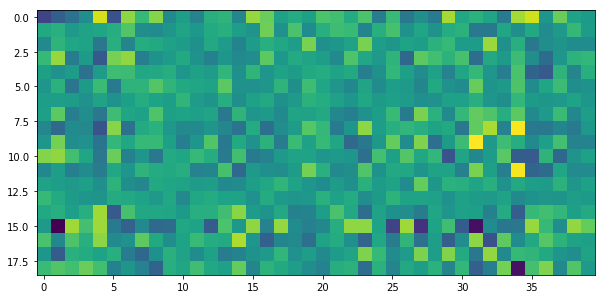

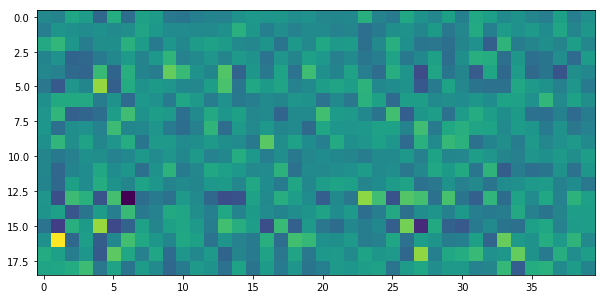

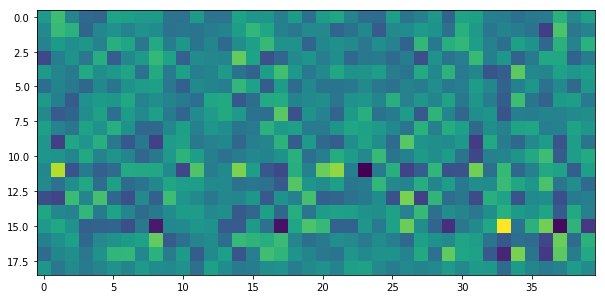

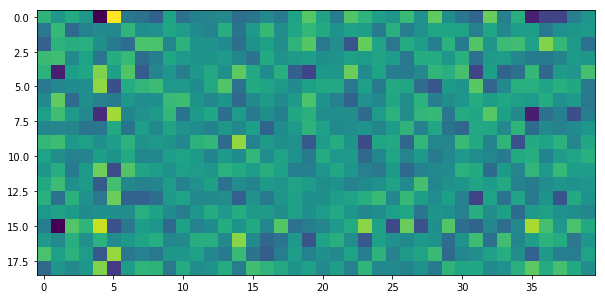

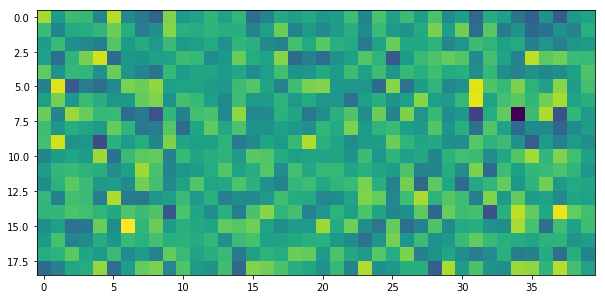

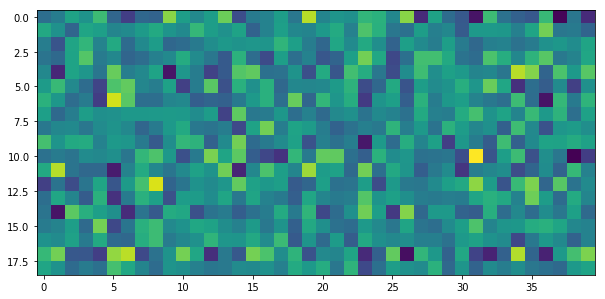

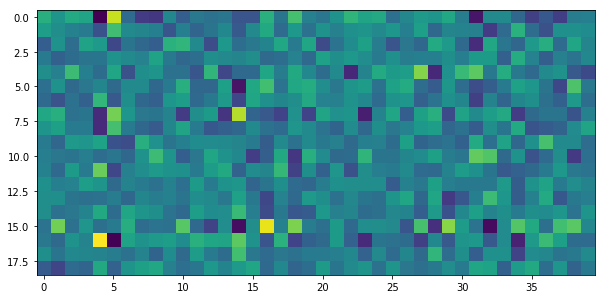

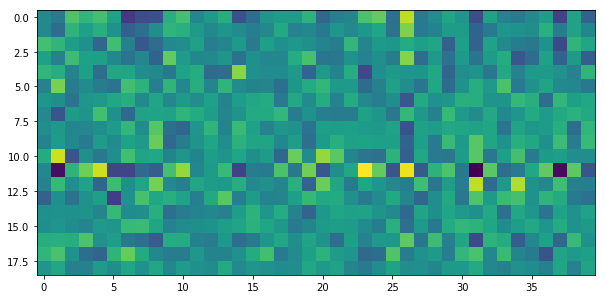

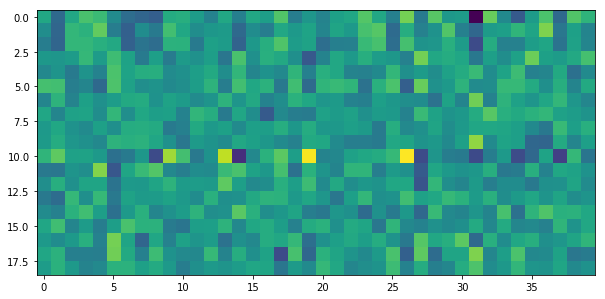

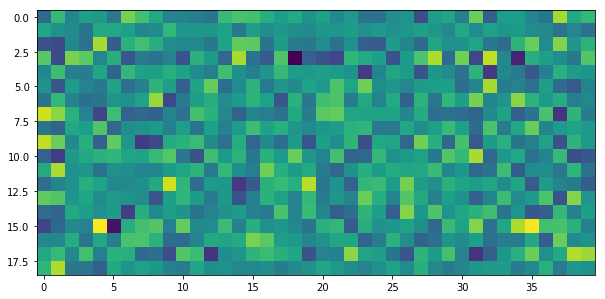

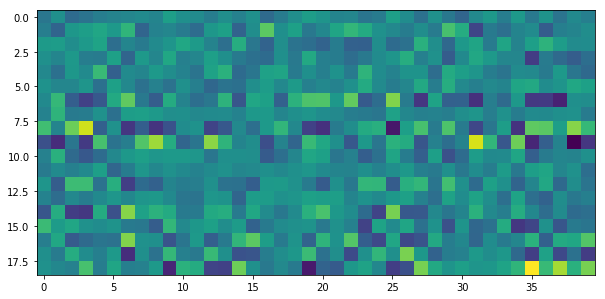

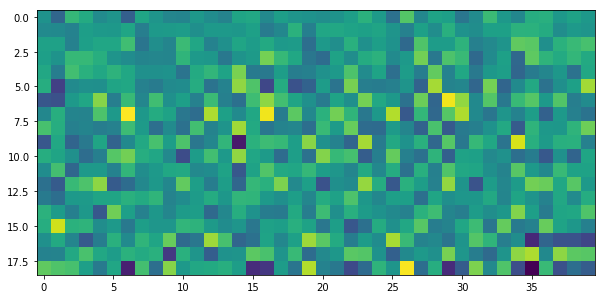

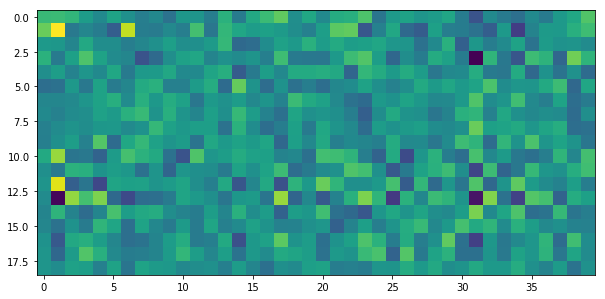

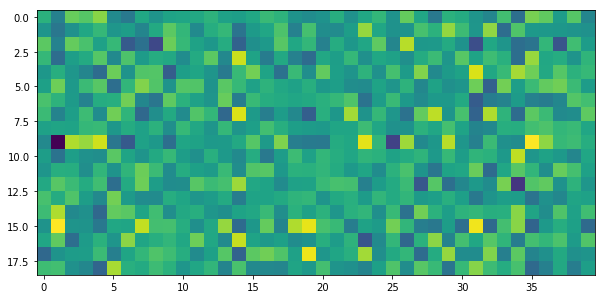

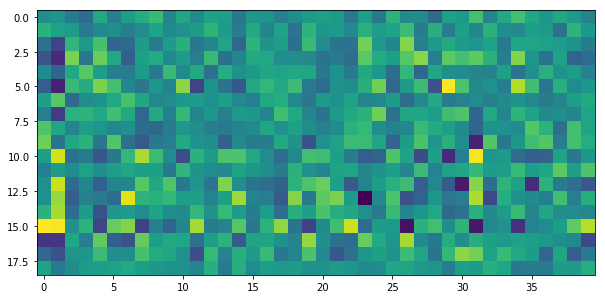

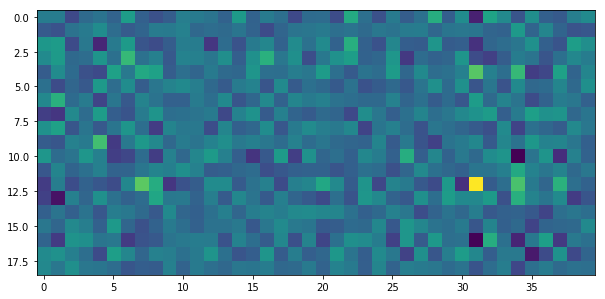

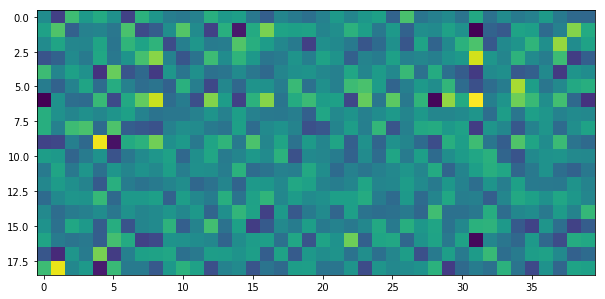

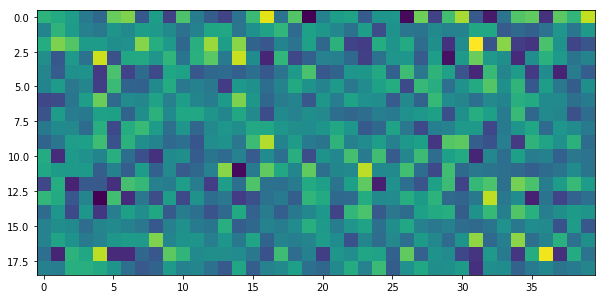

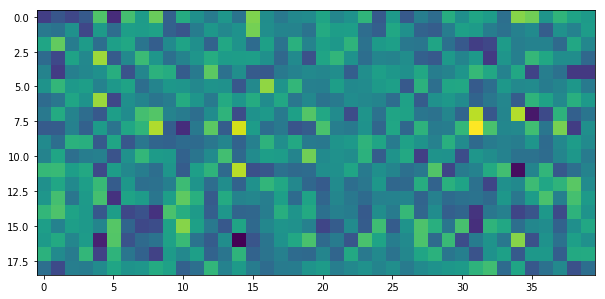

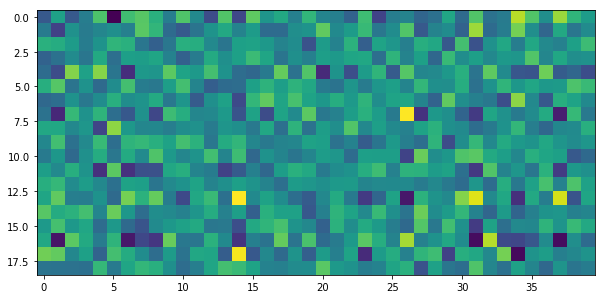

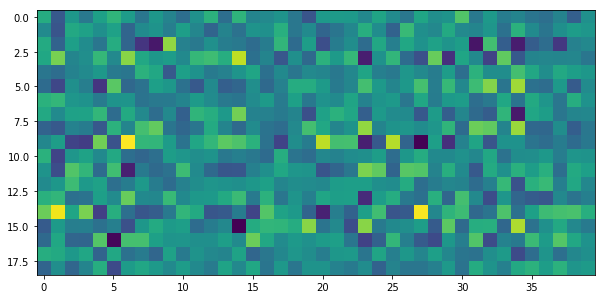

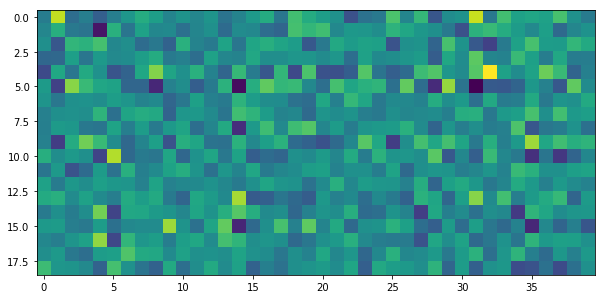

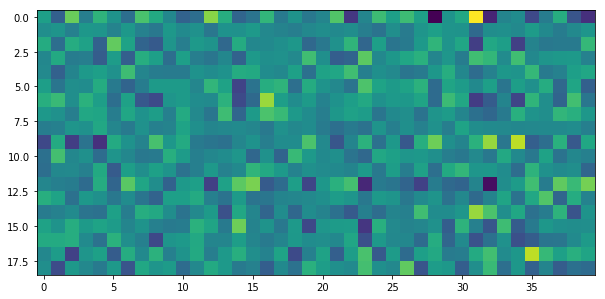

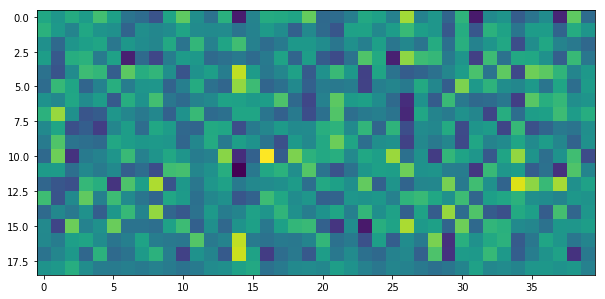

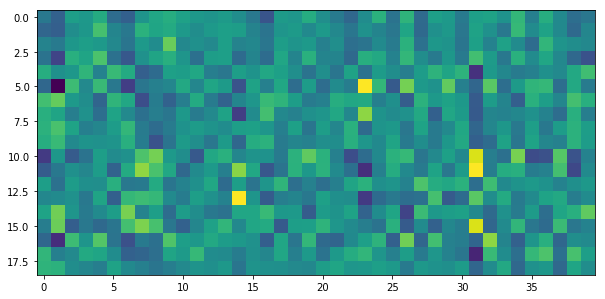

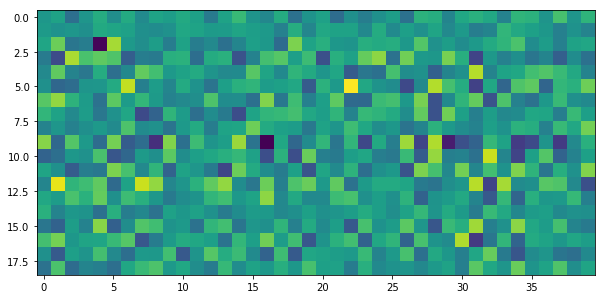

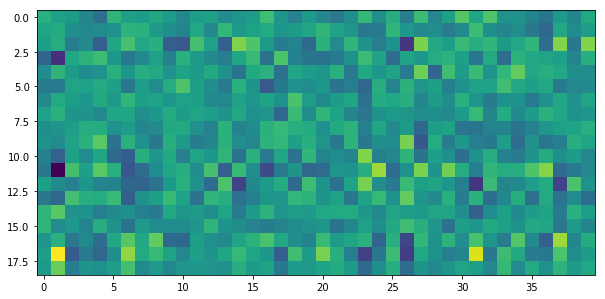

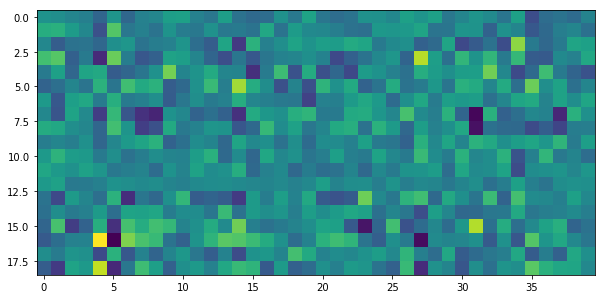

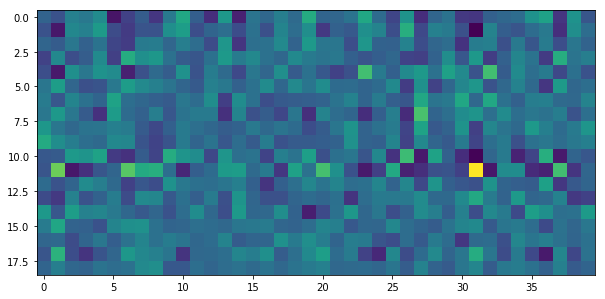

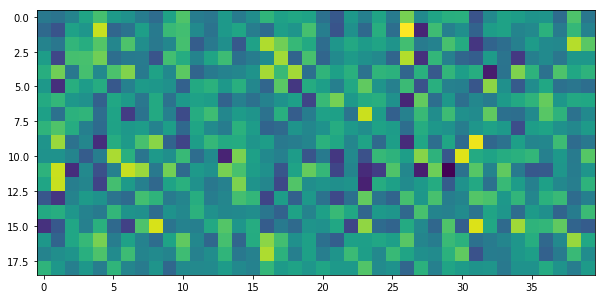

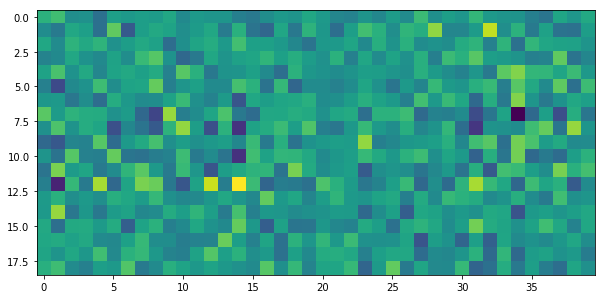

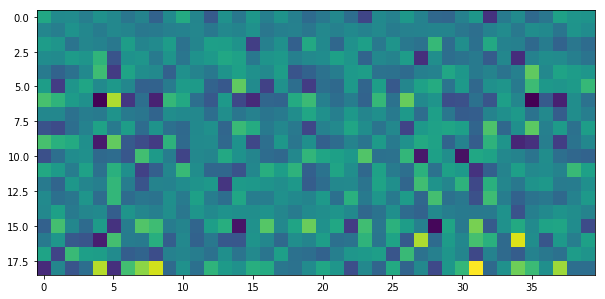

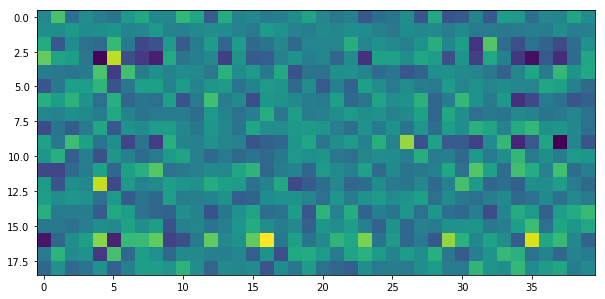

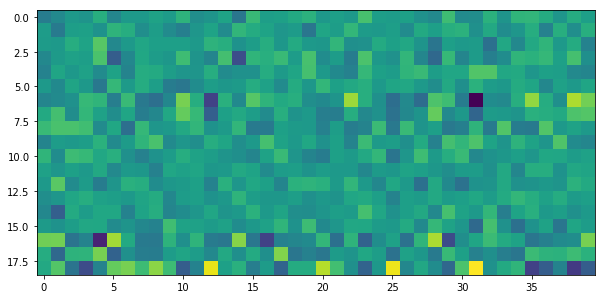

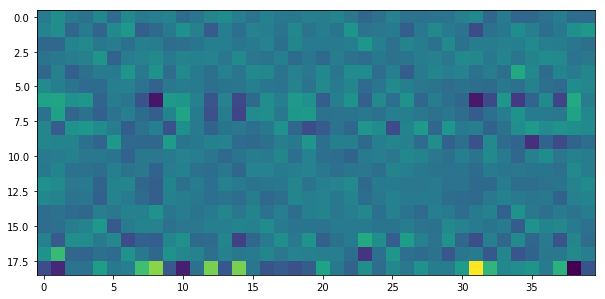

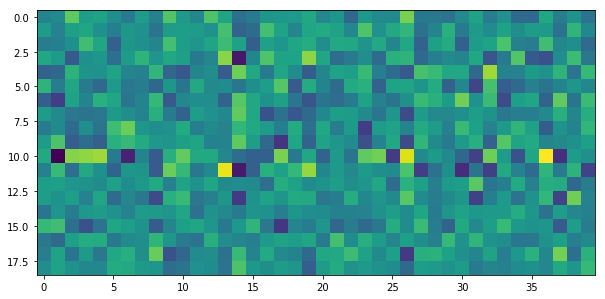

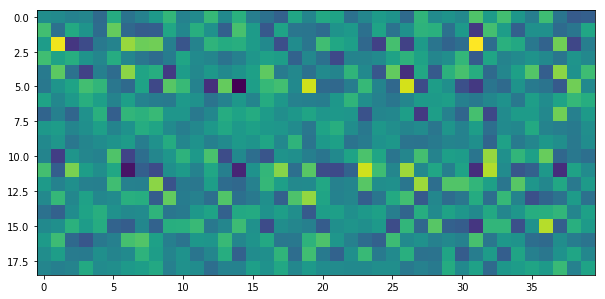

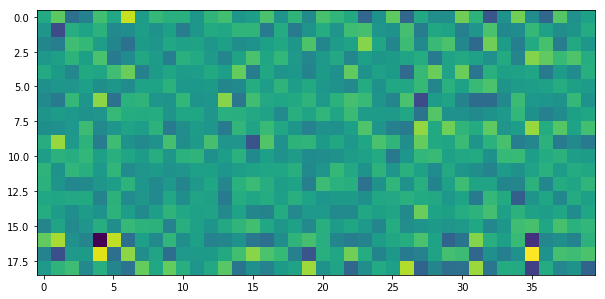

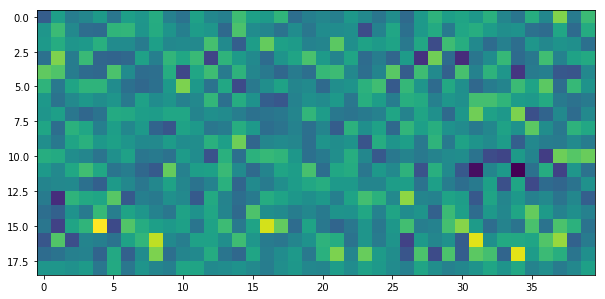

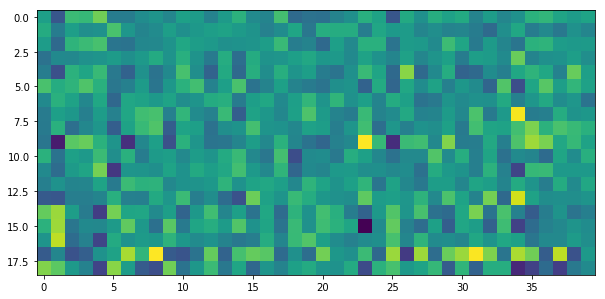

In [29]:
weights = model.get_weights()[1]
for channel in range(weights.shape[3]):
    plt.figure(figsize=(10,10))
    plt.imshow(weights[:, 0, :, channel])
    plt.plot()

## Evaluate with cross validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy
from sklearn.model_selection import GridSearchCV, train_test_split
from data.data_files import CHANNEL_NAMES, DataKind, files_builder
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

batch_size=128
seed = 123
numpy.random.seed(seed)

# fb = files_builder(DataKind('direct'), subfolder=())
fb = files_builder(DataKind('gaf'), subfolder=('cos_sim',))
# filenames, labels = fb.get_filenames_with_labels(label='resp', trial='a')
filenames, labels = fb.get_filenames_with_labels(label='dep')
filenames, labels = remove_middle(filenames, labels)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
mchp_filepath = '/home/kovar/thesis_project/data/models/weights_result_best.hdf5'
try:
    os.remove(mchp_filepath)
except:
    pass
cvscores = []
for i, (train, test) in enumerate(kfold.split(filenames, labels)):
    cat_labels = to_categorical(labels)

    training_filenames, validation_filenames, training_labels, validation_labels = \
        train_test_split(filenames[train], cat_labels[train], test_size=0.2, random_state=seed)

    training_batch_generator = batch_generator(training_filenames, training_labels, batch_size)
    validation_batch_generator = batch_generator(validation_filenames, validation_labels, batch_size)
    test_batch_generator = batch_generator(filenames[test], cat_labels[test], batch_size)

    # model = define_bd_shal_model(in_chans=19, input_time_length=256)
    # model = define_bd_deep_model(in_chans=19, input_time_length=256)
    model = define_temp()
    mcp = ModelCheckpoint(mchp_filepath, save_best_only=True, monitor='val_acc', save_weights_only=False)
    print('FOLD ', i+1)
    history = model.fit_generator(generator=training_batch_generator,
                                          steps_per_epoch=len(training_batch_generator),
                                          epochs=num_epochs,
                                          verbose=0,
                                          validation_data=validation_batch_generator,
                                          validation_steps=len(validation_batch_generator),
                                          callbacks=[
                                              mcp,
                                          #     # EarlyStopping(patience=4),
                                          #     ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, 
                                          #                       min_lr=0.001)
                                          ],
                                          use_multiprocessing=True,
                                          workers=8,
                                          max_queue_size=32)

    model = load_model(mchp_filepath)
    scores = model.evaluate_generator(test_batch_generator, steps=None, max_queue_size=10, workers=1, 
                             use_multiprocessing=False, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

FOLD  1
acc: 59.24%
FOLD  2
acc: 58.28%
FOLD  3
acc: 59.37%
FOLD  4
acc: 57.71%
FOLD  5


Process ForkPoolWorker-28889:
Process ForkPoolWorker-28895:
Process ForkPoolWorker-28894:
Process ForkPoolWorker-28893:
Process ForkPoolWorker-28884:
Process ForkPoolWorker-28883:
Process ForkPoolWorker-28881:
Process ForkPoolWorker-28896:
Process ForkPoolWorker-28886:
Process ForkPoolWorker-28887:
Process ForkPoolWorker-28885:
Process ForkPoolWorker-28892:
Process ForkPoolWorker-28882:
Process ForkPoolWorker-28888:
Process ForkPoolWorker-28890:
Process ForkPoolWorker-28891:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kovar/miniconda3/envs/thesis/lib/pytho

  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/synchronize.py", 

## Other

In [35]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    number_size = 4.0
    if K.floatx() == 'float16':
         number_size = 2.0
    if K.floatx() == 'float64':
         number_size = 8.0

    print('Total paramaters: {:,}'.format(trainable_count + non_trainable_count))
    total_memory = number_size*(batch_size*shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes
get_model_memory_usage(128, define_model_1())

Total paramaters: 12,694.0


2.518